In [1]:
from skimage.feature import graycomatrix, graycoprops
import os
import cv2
import numpy as np
from PIL import Image
from sklearn.linear_model import LinearRegression
import pandas as pd

def differential_box_counting(image, r):

    # Calculate image dimensions
    height, width = image.shape

    # Initialize an empty list to store the points (log 1/r, log Nr)
    points = []

    # Iterate over different values of r
    for r_value in r:
        # Initialize an empty list to store the differences for each box
        differences = []

        # Iterate over the grid
        for u in range(0, height, r_value):
            for v in range(0, width, r_value):
                # Calculate the maximum and minimum intensity values for the current box
                box = image[u:u+r_value, v:v+r_value]
                max_intensity = np.max(box)
                min_intensity = np.min(box)

                # Calculate the difference and add 1 to avoid zero values
                difference = max_intensity - min_intensity + 1
                differences.append(difference)

        # Calculate the sum of differences for this r_value
        Nr = np.sum(differences)

        # Calculate the point (log 1/r, log Nr)
        points.append([np.log(1/r_value), np.log(Nr)])

    # Perform linear regression to estimate the slope
    points = np.array(points)
    X = points[:, 0].reshape(-1, 1)
    y = points[:, 1]
    model = LinearRegression().fit(X, y)

    # The slope of the regression line represents the approximate fractal dimension
    fractal_dimension = model.coef_[0]

    return fractal_dimension

def calculate_lacunarity(image, r):

    # Calculate image dimensions
    height, width = image.shape

    # Initialize arrays to store N and P values
    N_values = []
    P_values = []

    # Iterate over different values of r
    for r_value in r:
        # Initialize a dictionary to store counts of differences for each box
        difference_counts = {}

        # Iterate over the grid
        for u in range(0, height, r_value):
            for v in range(0, width, r_value):
                # Calculate the maximum and minimum intensity values for the current box
                box = image[u:u+r_value, v:v+r_value]
                max_intensity = np.max(box)
                min_intensity = np.min(box)

                # Calculate the difference and add 1 to avoid zero values
                difference = max_intensity - min_intensity + 1

                # Update the count of this difference
                if difference in difference_counts:
                    difference_counts[difference] += 1
                else:
                    difference_counts[difference] = 1

        # Calculate N and P values
        N = sum(difference_counts.values())
        P = {k: v / N for k, v in difference_counts.items()}

        # Store N and P values
        N_values.append(N)
        P_values.append(P)

    # Calculate lacunarity
    numerator = sum([N ** 2 * sum([k ** 2 * v for k, v in P.items()]) for N, P in zip(N_values, P_values)])
    denominator = sum([N * sum([k * v for k, v in P.items()]) for N, P in zip(N_values, P_values)]) ** 2
    lacunarity = numerator / denominator

    return lacunarity

def calculate_statistics(image):
    # Generate GLCM
    distances = [50]  # Define distance for neighboring pixels
    #angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]  # Define angles for texture direction
    angles= [0]
    glcm = graycomatrix(image, distances=distances, angles=angles, levels=256)

    # Calculate features from GLCM
    contrast = graycoprops(glcm, 'contrast')
    dissimilarity = graycoprops(glcm, 'dissimilarity')
    homogeneity = graycoprops(glcm, 'homogeneity')
    energy = graycoprops(glcm, 'energy')
    correlation = graycoprops(glcm, 'correlation')

     # Normalize the GLCM
    glcm_sum = np.sum(glcm)
    glcm_normalized = glcm / glcm_sum

    # Calculate entropy
    entropy = -np.sum(glcm_normalized * np.log(glcm_normalized + 1e-10))

    # Calculate variance
    intensities = np.arange(256).reshape((256, 1, 1, 1))
    mean_intensity = np.sum(intensities * glcm_normalized)
    variance = np.sum(np.square(intensities - mean_intensity) * glcm_normalized)

    return contrast, dissimilarity, homogeneity, energy, correlation, entropy, variance

def process_images(folder_path, class_name, output_path, num_images=5):
    images_data = []
    
    # List all files in the folder
    files = os.listdir(folder_path)

    # Limit to the first `num_images` images
    #files = files[:num_images]

    # Iterate over each image file
    for i, file_name in enumerate(files, start=1):
        # Read the image
        image_path = os.path.join(folder_path, file_name)
        print("Load Image ", i)
        image = cv2.imread(image_path)

        # Split the image into RGB channels
        print(image_path)
        b, g, r = cv2.split(image)

        # Calculate fractal dimension, lacunarity, and statistics for each channel
        fractal_dimension_r = differential_box_counting(r, r_values)
        fractal_dimension_g = differential_box_counting(g, r_values)
        fractal_dimension_b = differential_box_counting(b, r_values)

        lacunarity_r = calculate_lacunarity(r, r_values)
        lacunarity_g = calculate_lacunarity(g, r_values)
        lacunarity_b = calculate_lacunarity(b, r_values)

        contrast_r, dissimilarity_r, homogeneity_r, energy_r, correlation_r, entropy_r, variance_r = calculate_statistics(r)
        contrast_g, dissimilarity_g, homogeneity_g, energy_g, correlation_g, entropy_g, variance_g = calculate_statistics(g)
        contrast_b, dissimilarity_b, homogeneity_b, energy_b, correlation_b, entropy_b, variance_b = calculate_statistics(b)

        # Append the data to the list
        images_data.append([i, fractal_dimension_r, lacunarity_r, contrast_r, dissimilarity_r, homogeneity_r, energy_r, correlation_r, entropy_r, variance_r])
        images_data.append([i, fractal_dimension_g, lacunarity_g, contrast_g, dissimilarity_g, homogeneity_g, energy_g, correlation_g, entropy_g, variance_g])
        images_data.append([i, fractal_dimension_b, lacunarity_b, contrast_b, dissimilarity_b, homogeneity_b, energy_b, correlation_b, entropy_b, variance_b])

    # Create a DataFrame from the list of data
    columns = ['Image Number', 'Fractal Dimension', 'Lacunarity', 'Contrast', 'Dissimilarity', 'Homogeneity', 'Energy', 'Correlation', 'Entropy', 'Variance']
    df = pd.DataFrame(images_data, columns=columns)

    # Save the DataFrame to a CSV file
    output_file = os.path.join(output_path, f"{class_name}.csv")
    df.to_csv(output_file, index=False)

# Define the folder paths
disc_folder_path = "C:\\Users\\saioc\\Desktop\\images\\disc"
exud_folder_path = r"C:\Users\saioc\Desktop\images\pete"

# Define output folder path
output_folder_path = r"C:\Users\saioc\Desktop\images\tables"

# Define r values for fractal dimension and lacunarity calculations
r_values = [1, 2, 4, 8, 16, 32, 64, 128, 256]

# Process images for 'disc' class
process_images(disc_folder_path, 'disc', output_folder_path)

# Process images for 'exud' class
process_images(exud_folder_path, 'exud', output_folder_path)



Load Image  1
C:\Users\saioc\Desktop\images\disc\1.png
Load Image  2
C:\Users\saioc\Desktop\images\disc\10.png
Load Image  3
C:\Users\saioc\Desktop\images\disc\100.png
Load Image  4
C:\Users\saioc\Desktop\images\disc\101.png
Load Image  5
C:\Users\saioc\Desktop\images\disc\102.png
Load Image  6
C:\Users\saioc\Desktop\images\disc\103.png
Load Image  7
C:\Users\saioc\Desktop\images\disc\104.png
Load Image  8
C:\Users\saioc\Desktop\images\disc\105.png
Load Image  9
C:\Users\saioc\Desktop\images\disc\106.png
Load Image  10
C:\Users\saioc\Desktop\images\disc\107.png
Load Image  11
C:\Users\saioc\Desktop\images\disc\108.png
Load Image  12
C:\Users\saioc\Desktop\images\disc\109.png
Load Image  13
C:\Users\saioc\Desktop\images\disc\11.png
Load Image  14
C:\Users\saioc\Desktop\images\disc\110.png
Load Image  15
C:\Users\saioc\Desktop\images\disc\111.png
Load Image  16
C:\Users\saioc\Desktop\images\disc\112.png
Load Image  17
C:\Users\saioc\Desktop\images\disc\113.png
Load Image  18
C:\Users\sai

In [102]:
import os
import cv2
import random

# Folder paths
disc_folder_path = "C:\\Users\\saioc\\Desktop\\images\\disc"
exud_folder_path = r"C:\Users\saioc\Desktop\\images\\pete"

# Function to display RGB channels of an image
# Function to display RGB channels of an image
def display_channels(image):
    # Split the image into RGB channels
    b, g, r = cv2.split(image)

    # Create a blank image of the same size as the original
    blank = np.zeros_like(b)

   

    # Display each channel
    cv2.imshow('Blue Channel', b)
    cv2.imshow('Green Channel', g)
    cv2.imshow('Red Channel', r)


# Function to display a random image from a folder
def display_random_image(folder_path):
    # List all files in the folder
    files = os.listdir(folder_path)

    # Choose a random image
    random_image = random.choice(files)
    image_path = os.path.join(folder_path, random_image)

    # Read the image
    image = cv2.imread(image_path)

    # Display the image
    cv2.imshow('Original Image', image)

    # Display the RGB channels
    display_channels(image)

    # Wait for a key press and close all windows
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# Display a random image from each folder
display_random_image(disc_folder_path)
display_random_image(exud_folder_path)


In [1]:
from skimage.feature import graycomatrix, graycoprops
import os
import cv2
import numpy as np
from PIL import Image
from sklearn.linear_model import LinearRegression
import pandas as pd

# Read CSV files for 'disc' and 'exud' classes
disc_data = pd.read_csv("C:\\Users\\saioc\\Desktop\\images\\tables\\disc.csv")
exud_data = pd.read_csv("C:\\Users\\saioc\\Desktop\\images\\tables\\exud.csv")

# Extract data for each channel from disc_data and exud_data
disc_r_data = disc_data[disc_data.index % 3 == 0].reset_index(drop=True)
disc_g_data = disc_data[disc_data.index % 3 == 1].reset_index(drop=True)
disc_b_data = disc_data[disc_data.index % 3 == 2].reset_index(drop=True)


exud_r_data = exud_data[exud_data.index % 3 == 0].reset_index(drop=True)
exud_g_data = exud_data[exud_data.index % 3 == 1].reset_index(drop=True)
exud_b_data = exud_data[exud_data.index % 3 == 2].reset_index(drop=True)

disc_table = disc_g_data
exud_table = exud_g_data





In [94]:
# !!!!!!!!! NU RULA

import pandas as pd
import ast

# Function to remove brackets from string representation of list and convert to float
def remove_brackets(value):
    try:
        return float(ast.literal_eval(value)[0][0])
    except (ValueError, IndexError, TypeError):
        return value

# Function to modify the dataframe
def modify_dataframe(file_path):
    # Read the CSV file
    df = pd.read_csv(file_path)

    # Double the values in the "Fractal Dimension" column
    df['Fractal Dimension'] = df['Fractal Dimension'] * 2
    

    # Columns to remove brackets from
    columns_to_modify = ['Contrast', 'Dissimilarity', 'Homogeneity', 'Energy', 'Correlation']

    # Apply the bracket removal function to the specified columns
    for column in columns_to_modify:
        df[column] = df[column].apply(remove_brackets)

    # Save the modified dataframe back to the CSV file
    df.to_csv(file_path, index=False)

# File paths
disc_file_path = "C:\\Users\\saioc\\Desktop\\images\\tables\\disc.csv"
exud_file_path = "C:\\Users\\saioc\\Desktop\\images\\tables\\exud.csv"

# Modify the dataframes
modify_dataframe(disc_file_path)
modify_dataframe(exud_file_path)

# !!!!!!!!!!! NU RULA

In [95]:
print(disc_r_data)

     Image Number  Fractal Dimension  Lacunarity     Contrast  Dissimilarity  \
0               1           2.250797    0.356922   790.233879      17.588579   
1               2           2.216845    0.319775   922.829386      21.074071   
2               3           2.218267    0.328313   630.127829      18.557143   
3               4           2.190051    0.327230   600.281421      18.696264   
4               5           2.166490    0.319742   755.172414      21.244971   
..            ...                ...         ...          ...            ...   
162           163           2.219187    0.325673   745.223950      20.950950   
163           164           2.131299    0.304390  1074.940721      25.124821   
164           165           2.117818    0.313217  1125.460950      25.345136   
165           166           2.139371    0.311756  1210.329036      25.160136   
166           167           2.144670    0.306198  1164.467050      25.173593   

     Homogeneity    Energy  Correlation

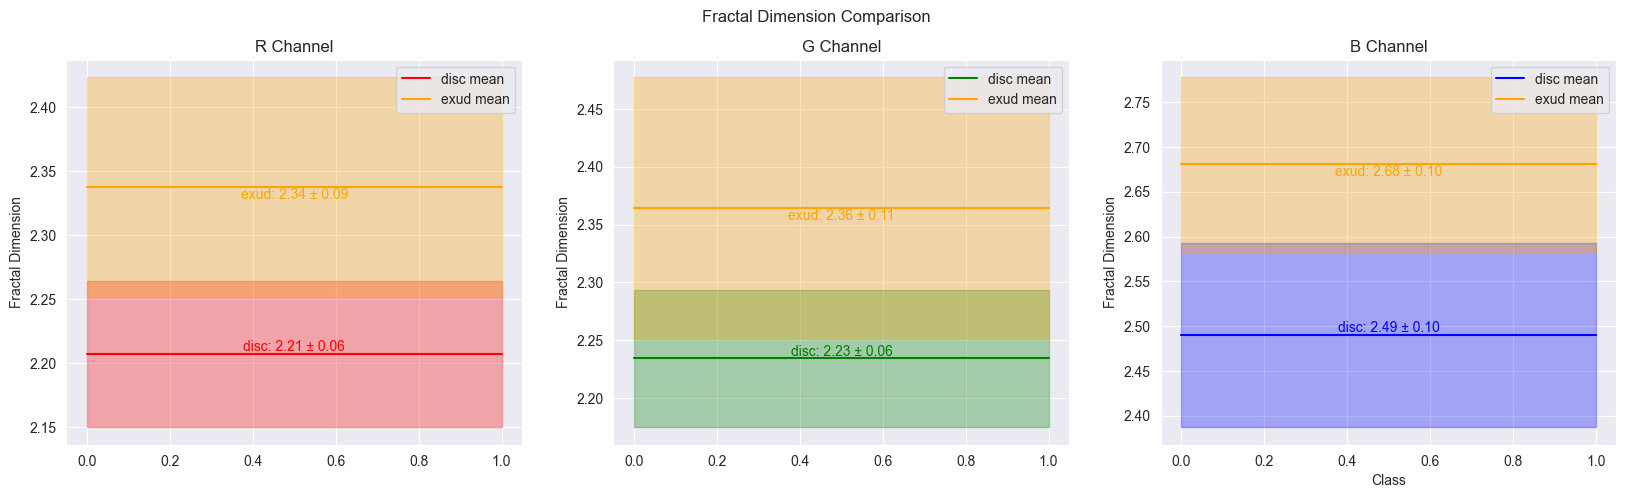

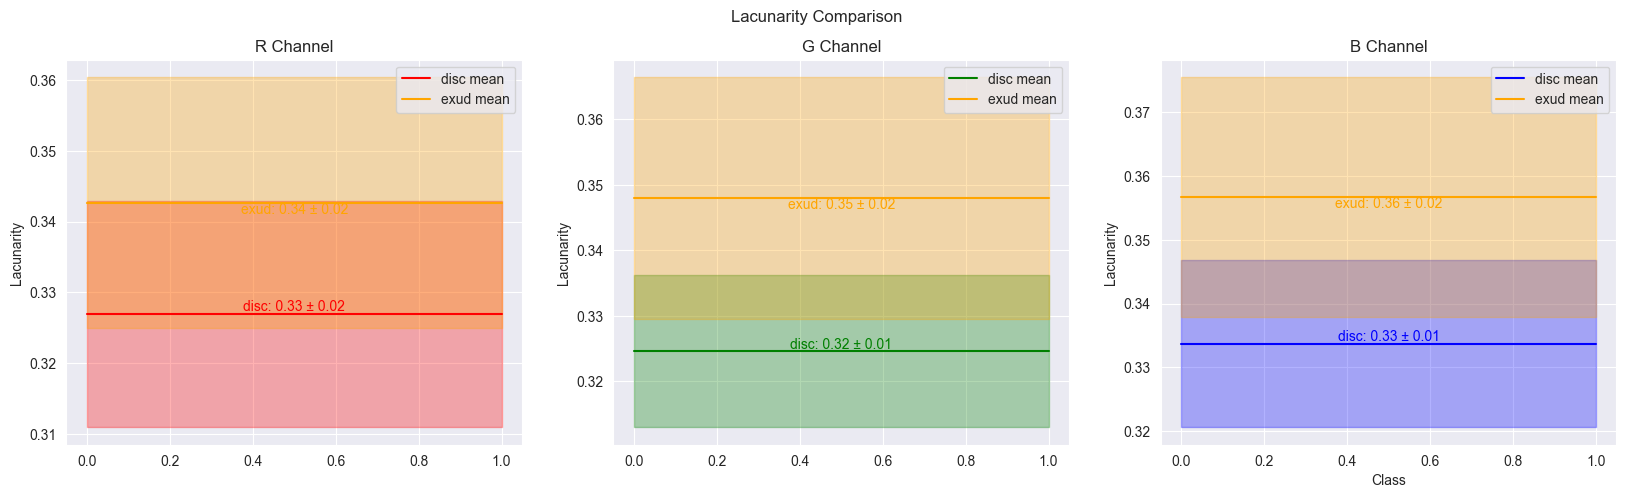

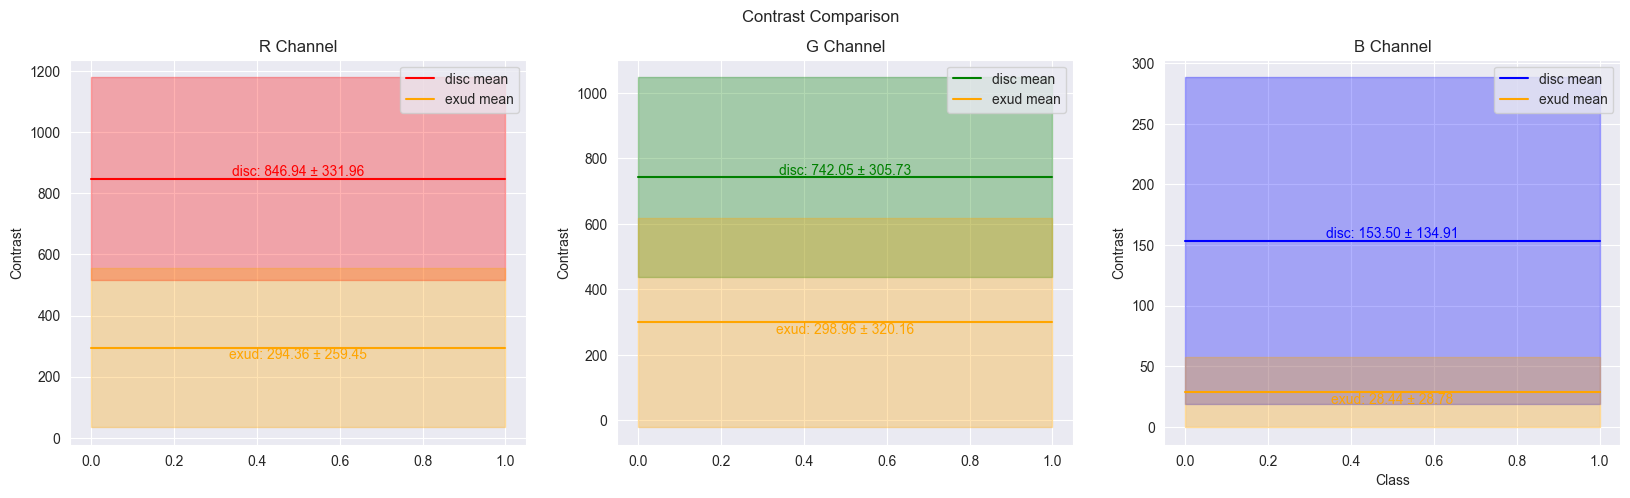

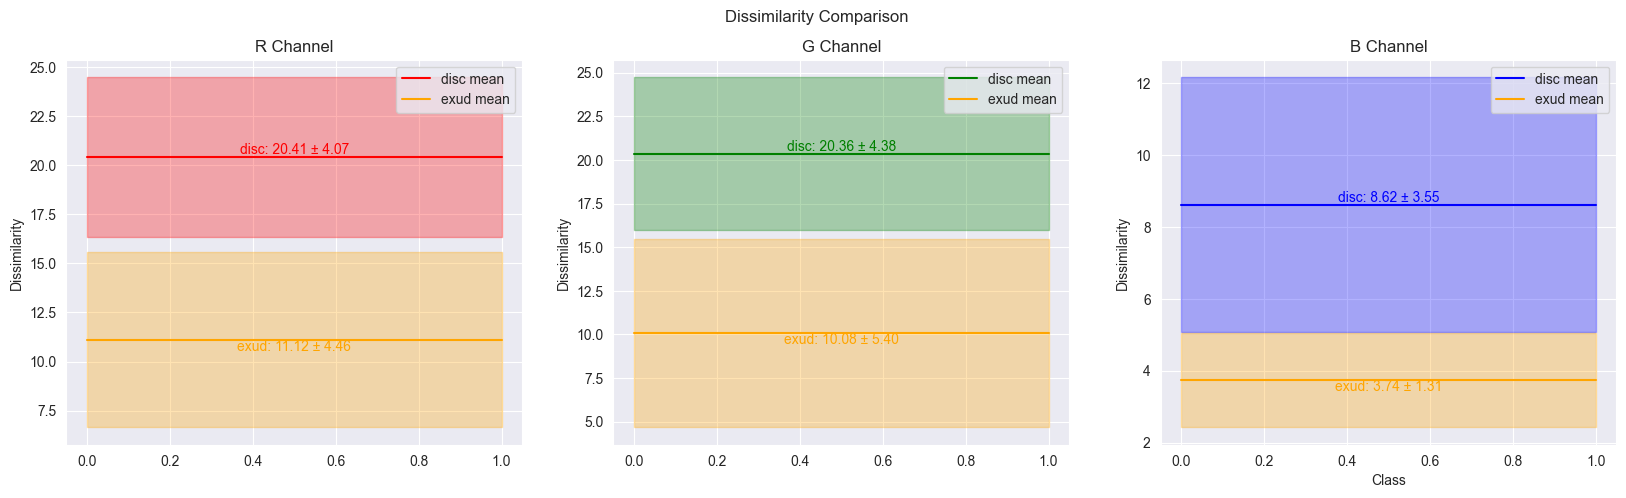

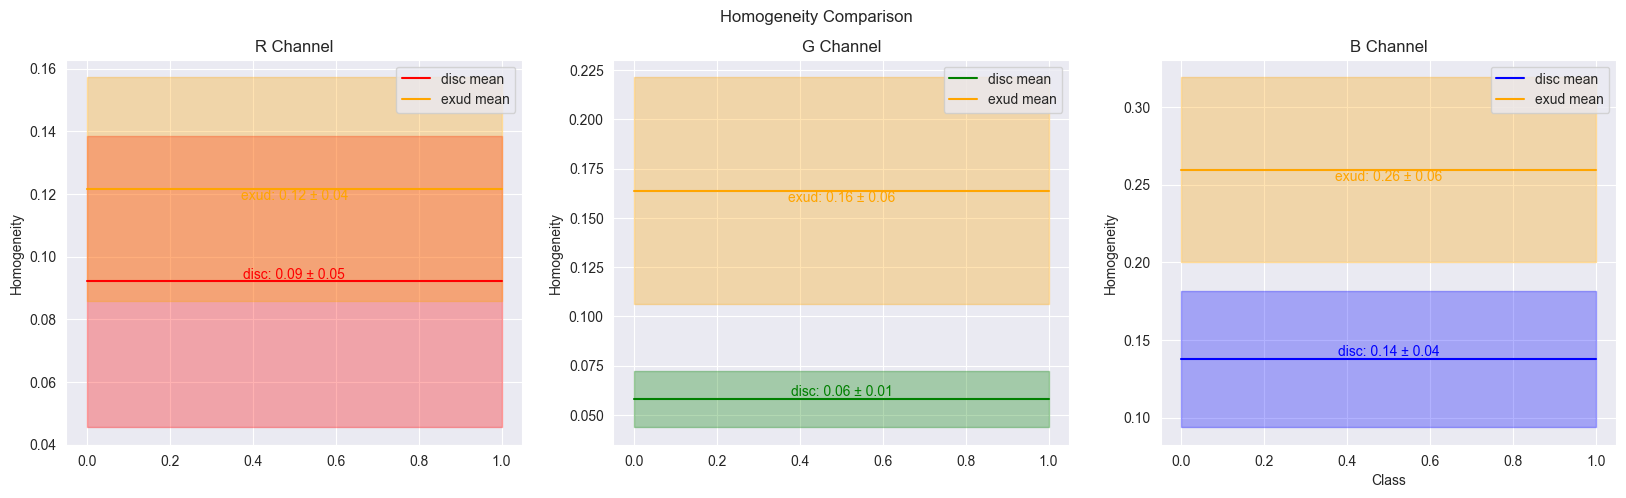

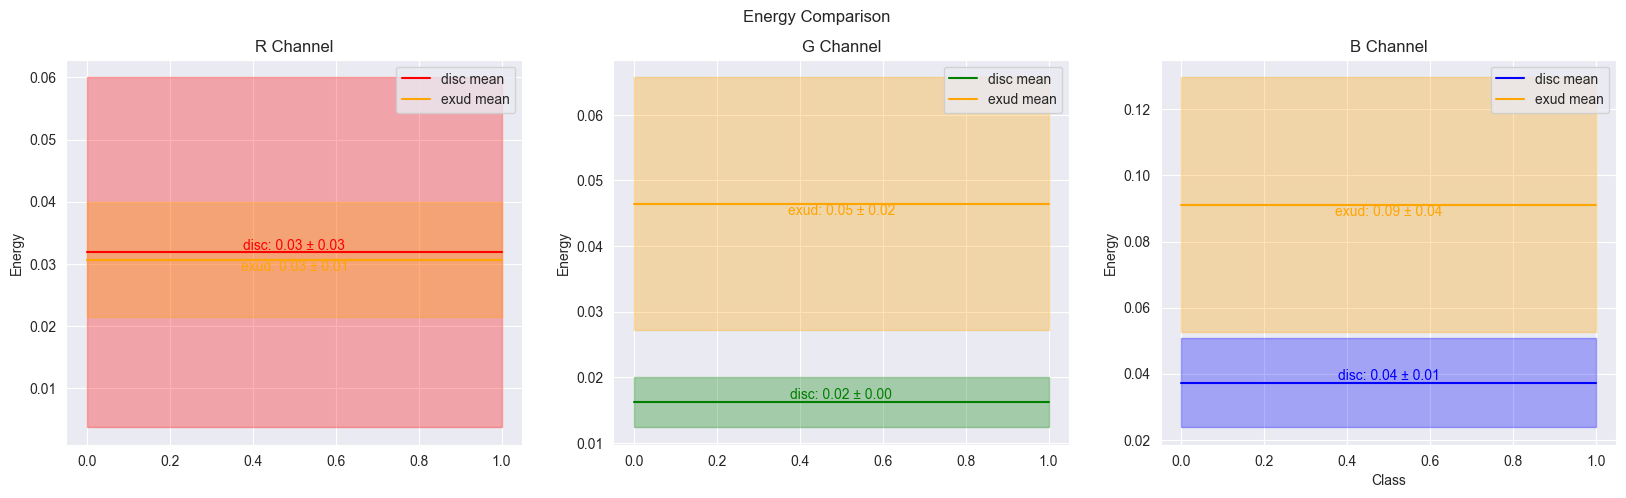

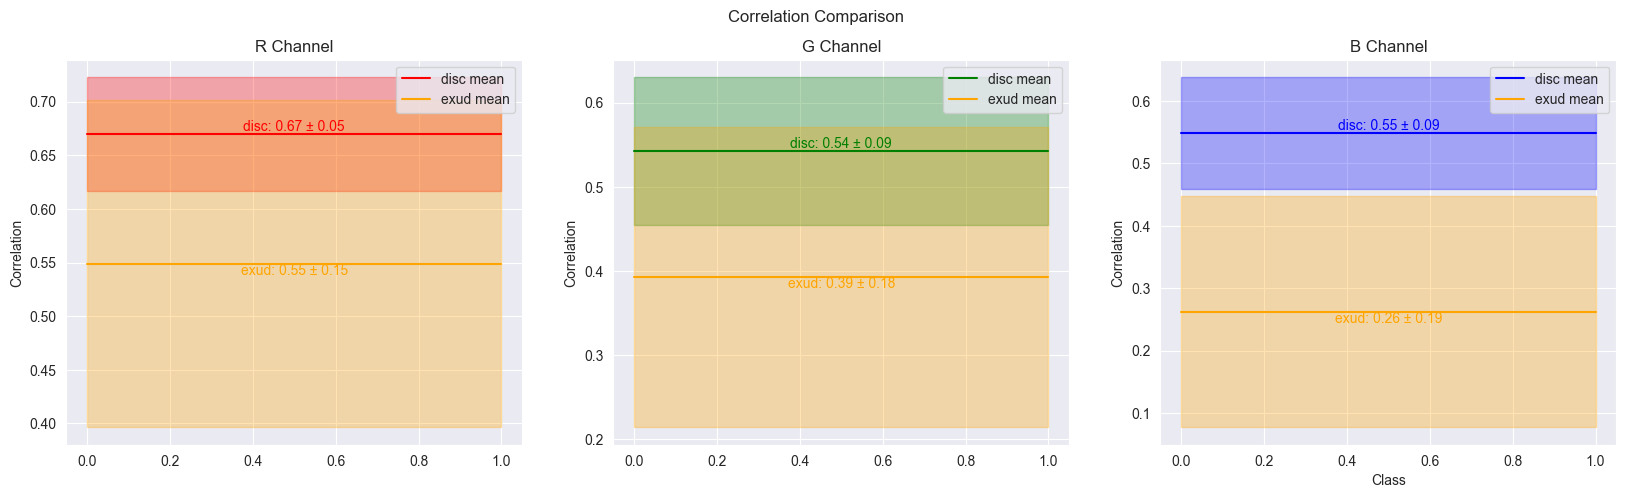

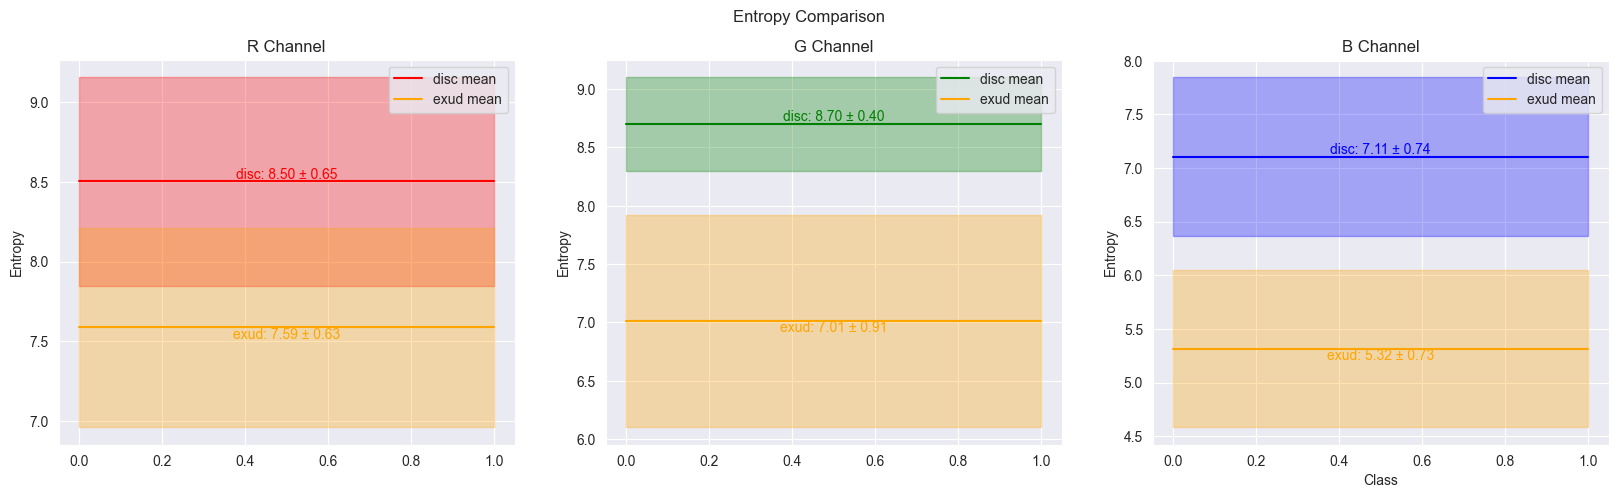

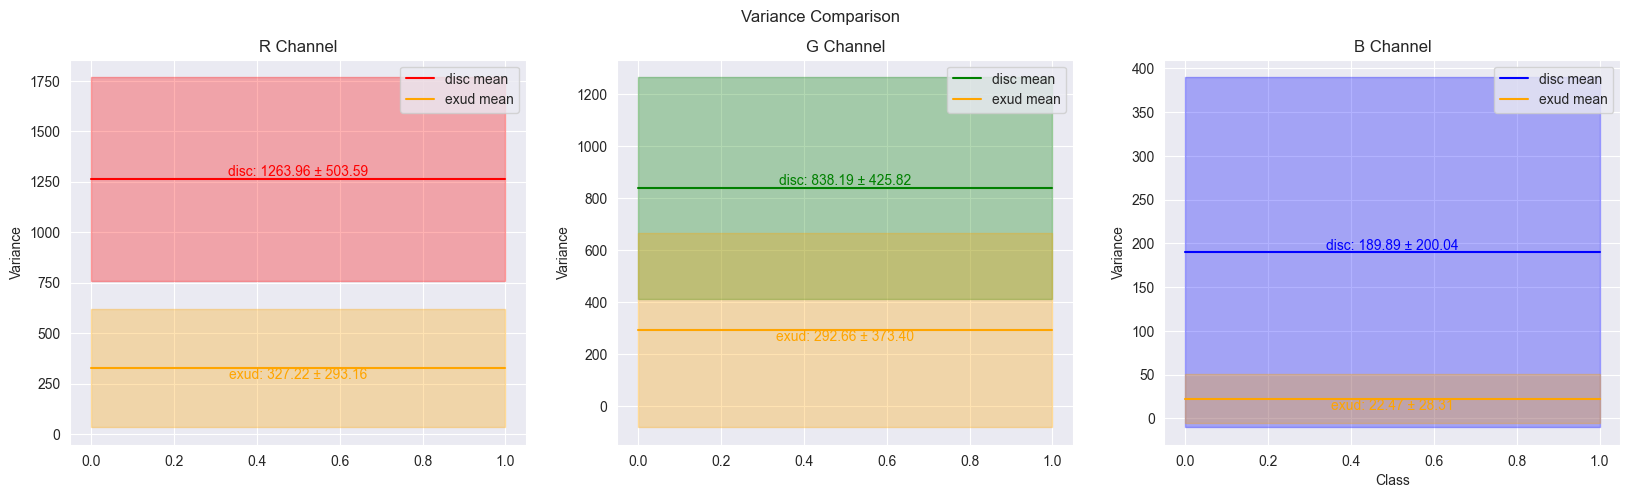

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Define the features to plot
features = ['Fractal Dimension', 'Lacunarity', 'Contrast', 'Dissimilarity', 'Homogeneity', 'Energy', 'Correlation', 'Entropy', 'Variance']


# Define the data for each channel
data_dict = {
    'R Channel': (disc_r_data, exud_r_data, 'red'),
    'G Channel': (disc_g_data, exud_g_data, 'green'),
    'B Channel': (disc_b_data, exud_b_data, 'blue')
}

# Iterate over each feature
for feature in features:
    # Create a plot for the feature with 3 subplots in a row
    fig, axs = plt.subplots(1, 3, figsize=(20, 5))
    fig.suptitle(f'{feature} Comparison')

    # Iterate over each color channel
    for ax, (channel, (disc_data, exud_data, color)) in zip(axs, data_dict.items()):
        # Calculate mean and standard deviation for each class
        disc_mean = disc_data[feature].mean()
        disc_std = disc_data[feature].std()
        exud_mean = exud_data[feature].mean()
        exud_std = exud_data[feature].std()

        # Plot the mean with standard deviation as a colored band for each class
        ax.fill_between([0, 1], [disc_mean - disc_std, disc_mean - disc_std], [disc_mean + disc_std, disc_mean + disc_std], color=color, alpha=0.3)
        ax.fill_between([0, 1], [exud_mean - exud_std, exud_mean - exud_std], [exud_mean + exud_std, exud_mean + exud_std], color='orange', alpha=0.3)

        # Plot the mean as lines
        ax.plot([0, 1], [disc_mean, disc_mean], label='disc mean', color=color)
        ax.plot([0, 1], [exud_mean, exud_mean], label='exud mean', color='orange')

        # Add text to show the mean ± standard deviation
        ax.text(0.5, disc_mean, f'disc: {disc_mean:.2f} ± {disc_std:.2f}', color=color, ha='center', va='bottom')
        ax.text(0.5, exud_mean, f'exud: {exud_mean:.2f} ± {exud_std:.2f}', color='orange', ha='center', va='top')

        # Set title and labels
        ax.set_title(channel)
        ax.set_ylabel(feature)
        ax.legend()

    plt.xlabel('Class')
    plt.show()


In [102]:
import matplotlib.pyplot as plt

# Define the features to plot
features = ['Fractal Dimension', 'Lacunarity', 'Contrast', 'Dissimilarity', 'Homogeneity', 'Energy', 'Correlation', 'Entropy', 'Variance']

# Iterate over each feature
for feature in features:
    # Create subplots for each channel and average
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'{feature} Comparison')

    # Plot 'disc' class data
    axs[0, 0].plot(disc_r_data['Image Number'], disc_r_data[feature], label='disc_r', color='blue')
    axs[0, 0].plot(exud_r_data['Image Number'], exud_r_data[feature], label='exud_r', color='cyan')
    axs[0, 0].set_title('R Channel')
    axs[0, 0].legend()
    axs[0, 1].plot(disc_g_data['Image Number'], disc_g_data[feature], label='disc_g', color='green')
    axs[0, 1].plot(exud_g_data['Image Number'], exud_g_data[feature], label='exud_g', color='magenta')
    axs[0, 1].set_title('G Channel')
    axs[0, 1].legend()
    axs[1, 0].plot(disc_b_data['Image Number'], disc_b_data[feature], label='disc_b', color='red')
    axs[1, 0].plot(exud_b_data['Image Number'], exud_b_data[feature], label='exud_b', color='yellow')
    axs[1, 0].set_title('B Channel')
    axs[1, 0].legend()

    # Set common labels
    for ax in axs.flat:
        ax.set(xlabel='Image Number', ylabel=feature)

    # Hide x labels and tick labels for top plots and y ticks for right plots
    for ax in axs.flat:
        ax.label_outer()

    plt.show()


In [2]:
import pandas as pd

# Features to extract from each color channel
feature_channel_map = {
    'Fractal Dimension': 'b',
    'Lacunarity': 'g',
    'Contrast': 'r',
    'Dissimilarity': 'r',
    'Homogeneity': 'g',
    'Energy': 'g',
    'Correlation': 'b',
    'Entropy': 'b',
    'Variance': 'r'
}

# Initialize dictionaries to store the selected data
disc_selected_data = {}
exud_selected_data = {}

# Iterate over the feature-channel mapping
for feature, channel in feature_channel_map.items():
    # Extract the corresponding data for disc and exud classes
    if channel == 'r':
        disc_selected_data[feature] = disc_r_data[feature]
        exud_selected_data[feature] = exud_r_data[feature]
    elif channel == 'g':
        disc_selected_data[feature] = disc_g_data[feature]
        exud_selected_data[feature] = exud_g_data[feature]
    elif channel == 'b':
        disc_selected_data[feature] = disc_b_data[feature]
        exud_selected_data[feature] = exud_b_data[feature]

# Convert the dictionaries to DataFrames
disc_table = pd.DataFrame(disc_selected_data)
exud_table = pd.DataFrame(exud_selected_data)

# Display the resulting tables
print("Disc Table:")
print(disc_table.head())
print("\nExud Table:")
print(exud_table.head())


Disc Table:
   Fractal Dimension  Lacunarity    Contrast  Dissimilarity  Homogeneity  \
0           2.368381    0.328073  790.233879      17.588579     0.053665   
1           2.593298    0.319186  922.829386      21.074071     0.050897   
2           2.450573    0.321587  630.127829      18.557143     0.062106   
3           2.417170    0.324811  600.281421      18.696264     0.057377   
4           2.441856    0.329164  755.172414      21.244971     0.070779   

     Energy  Correlation   Entropy     Variance  
0  0.013683     0.657397  7.826556  1068.275880  
1  0.015064     0.427426  6.479767  1103.289431  
2  0.015428     0.659112  7.454821   964.045637  
3  0.015507     0.591403  7.335597  1027.571550  
4  0.020400     0.595896  7.184670  1428.536017  

Exud Table:
   Fractal Dimension  Lacunarity    Contrast  Dissimilarity  Homogeneity  \
0           2.543267    0.393997  307.307179       9.289264     0.157991   
1           2.673243    0.383266  170.776693       8.428679     0.

In [3]:
import pandas as pd

# Add a 'Type' column to indicate whether the data is from 'disc' or 'exud'
disc_r_data['Type'] = 'disc'
exud_r_data['Type'] = 'exud'
disc_g_data['Type'] = 'disc'
exud_g_data['Type'] = 'exud'
disc_b_data['Type'] = 'disc'
exud_b_data['Type'] = 'exud'
disc_table['Type'] = 'disc'
exud_table['Type'] = 'exud'

# Concatenate disc and exud data for each channel to create separate dataframes
r_data = pd.concat([disc_r_data, exud_r_data]).reset_index(drop=True)
g_data = pd.concat([disc_g_data, exud_g_data]).reset_index(drop=True)
b_data = pd.concat([disc_b_data, exud_b_data]).reset_index(drop=True)
avg_data = pd.concat([disc_table, exud_table]).reset_index(drop=True)

from sklearn.preprocessing import MinMaxScaler

# Specify the columns you want to normalize
columns_to_normalize = ['Fractal Dimension', 'Contrast', 'Dissimilarity', 'Entropy', 'Variance']

# Create a MinMaxScaler instance
scaler = MinMaxScaler()

# Fit and transform the selected columns
avg_data[columns_to_normalize] = scaler.fit_transform(avg_data[columns_to_normalize])



In [129]:
avg_data.head()

,Image Number,Fractal Dimension,Lacunarity,Contrast,Dissimilarity,Homogeneity,Energy,Correlation,Entropy,Variance,Type
0,1,0.163000,0.328073,0.398251,0.607774,0.053665,0.013683,0.644671,0.854878,0.388134,disc
1,2,0.347715,0.319186,0.380803,0.596870,0.050897,0.015064,0.280893,0.792166,0.159177,disc
2,3,0.261250,0.321587,0.376509,0.559281,0.062106,0.015428,0.627560,0.812172,0.310279,disc
3,4,0.168904,0.324811,0.429280,0.601289,0.057377,0.015507,0.597290,0.821925,0.350941,disc
4,5,0.280657,0.329164,0.317652,0.478643,0.070779,0.020400,0.627589,0.718399,0.286616,disc


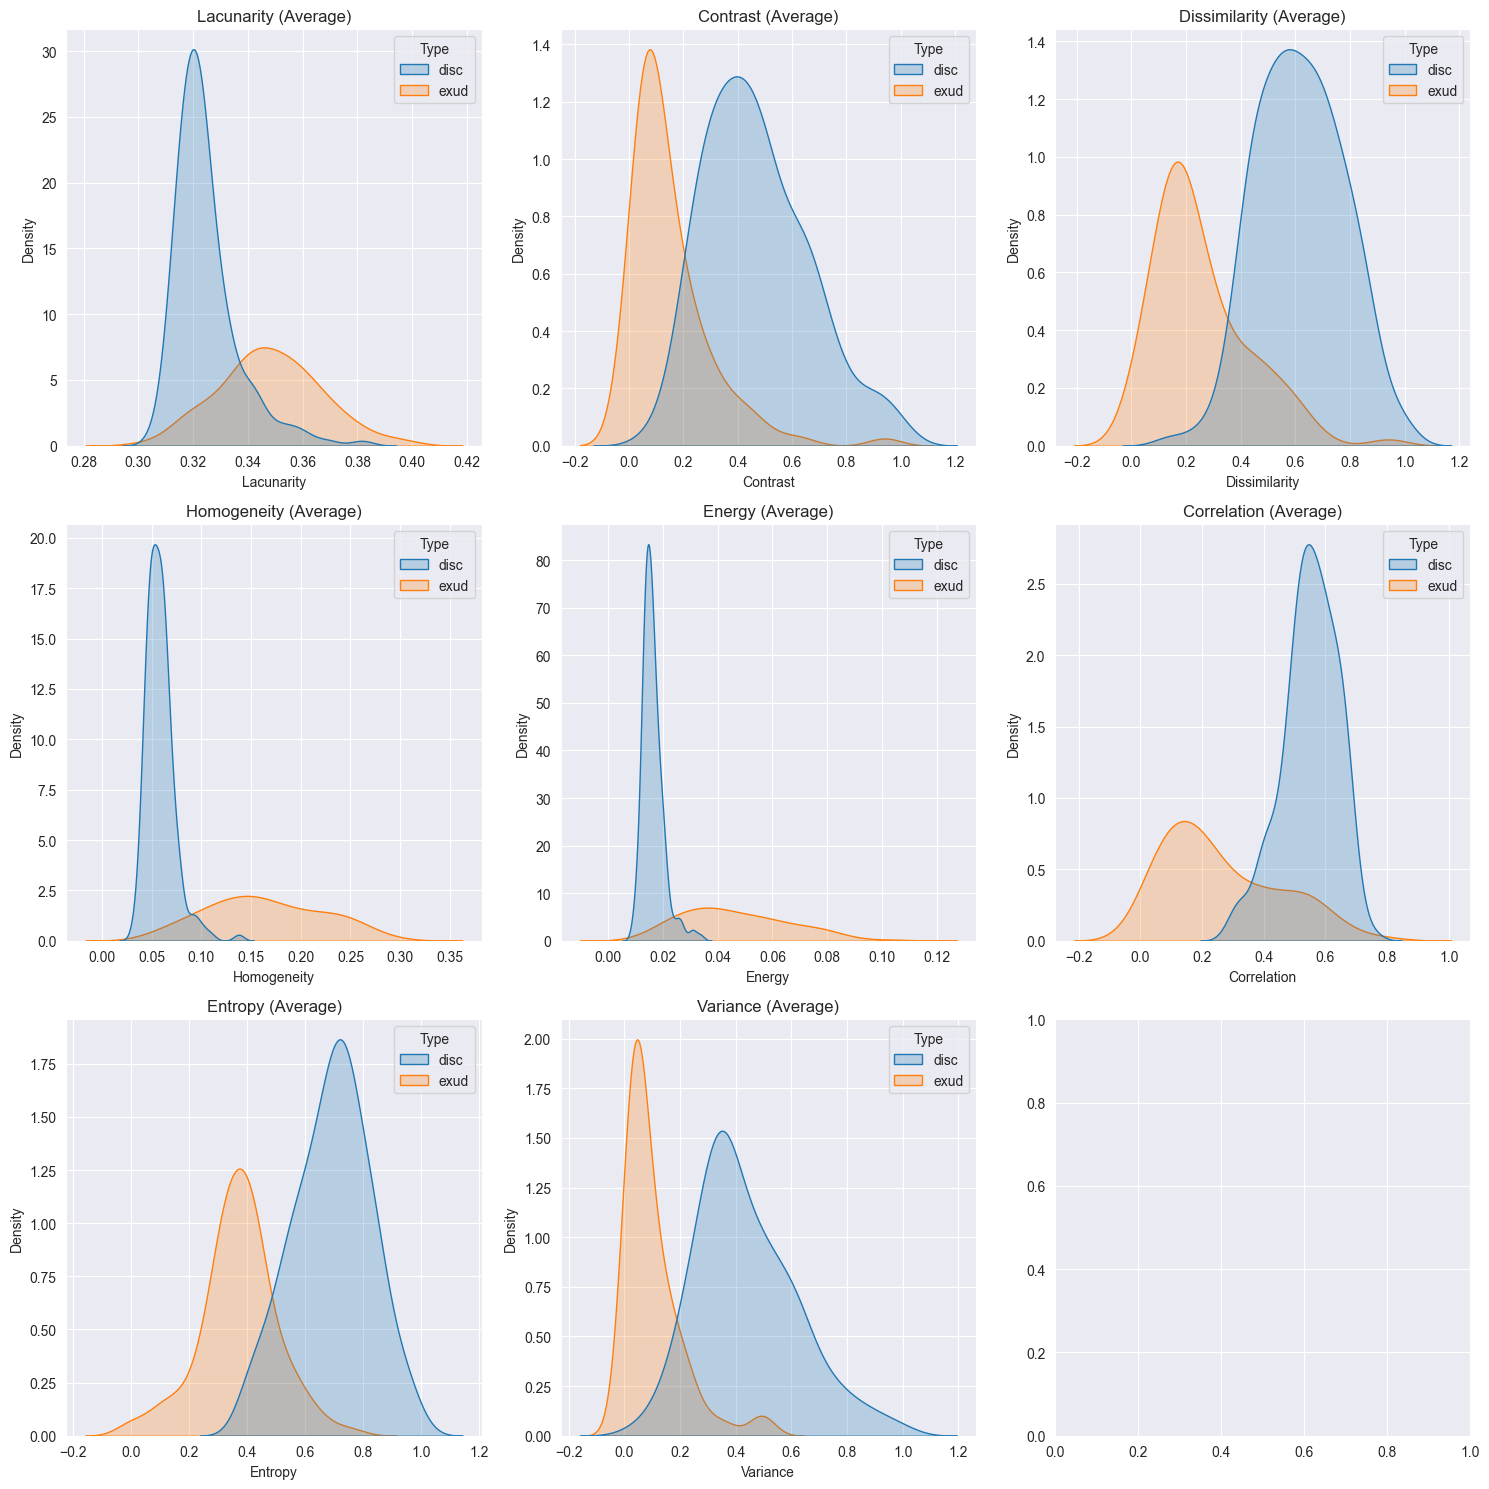

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the features to plot
features = ['Fractal Dimension', 'Lacunarity', 'Contrast', 'Dissimilarity', 'Homogeneity', 'Energy', 'Correlation', 'Entropy', 'Variance']

# Create subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

# Iterate over features
for i, feature in enumerate(features):
    # Calculate row and column indices
    row_idx = i // 3  # Integer division to determine the row index
    col_idx = i % 3   # Modulus operator to determine the column index
    
    # Plot for avg_data
    sns.kdeplot(data=avg_data, x=feature, hue="Type", fill=True, ax=axes[row_idx, col_idx])
    axes[row_idx, col_idx].set_title(f'{feature} (Average)')

# Adjust layout
plt.tight_layout()
plt.show()


In [5]:
avg_data["Type"] = avg_data["Type"].replace("disc", 1)
avg_data["Type"] = avg_data["Type"].replace("exud", 0)

avg_data.head()

C:\Users\saioc\AppData\Local\Temp\ipykernel_17104\3019216848.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  avg_data["Type"] = avg_data["Type"].replace("exud", 0)


,Fractal Dimension,Lacunarity,Contrast,Dissimilarity,Homogeneity,Energy,Correlation,Entropy,Variance,Type
0,0.227467,0.328073,0.437224,0.506159,0.053665,0.013683,0.657397,0.820090,0.368341,1
1,0.525837,0.319186,0.513860,0.642012,0.050897,0.015064,0.427426,0.578569,0.380944,1
2,0.336502,0.321587,0.344688,0.543911,0.062106,0.015428,0.659112,0.753426,0.330825,1
3,0.292190,0.324811,0.327437,0.549333,0.057377,0.015507,0.591403,0.732046,0.353690,1
4,0.324938,0.329164,0.416959,0.648673,0.070779,0.020400,0.595896,0.704980,0.498013,1


In [30]:
# importing packages
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

columns = [ 'Dissimilarity', 'Homogeneity', 'Energy', 'Correlation', 'Entropy', 'Variance']
train_X, val_X, train_y, val_y = train_test_split(avg_data[columns], avg_data["Type"], test_size=0.30, random_state=42)
train_X.head()

,Dissimilarity,Homogeneity,Energy,Correlation,Entropy,Variance
69,0.593885,0.076978,0.017061,0.526774,0.558530,0.475755
2,0.543911,0.062106,0.015428,0.659112,0.753426,0.330825
147,0.845611,0.036113,0.010461,0.597606,0.947362,0.489223
117,0.507229,0.054979,0.015567,0.550855,0.695149,0.320763
154,0.569076,0.060905,0.018143,0.522040,0.713622,0.427213


In [86]:
print("The shape of X_train is      ", train_X.shape)
print("The shape of X_test is       ", val_X.shape)
print("The shape of y_train is      ", train_y.shape)
print("The shape of y_test is       ", val_y.shape)

The shape of X_train is       (182, 7)
The shape of X_test is        (79, 7)
The shape of y_train is       (182,)
The shape of y_test is        (79,)


In [87]:
# Assuming train_X is a pandas DataFrame
missing_data = train_X.isnull().sum()

# Display the count of missing values for each column
print("Missing Data Counts:")
print(missing_data)

# Display the columns with missing values
columns_with_missing_data = missing_data[missing_data > 0].index
print("\nColumns with Missing Data:")
print(columns_with_missing_data)

Missing Data Counts:
Contrast         0
Dissimilarity    0
Homogeneity      0
Energy           0
Correlation      0
Entropy          0
Variance         0
dtype: int64

Columns with Missing Data:
Index([], dtype='object')


In [31]:
lr = LogisticRegression(random_state=0)
knn = KNeighborsClassifier()
svc = SVC(random_state=0)
gnb = GaussianNB()
dtc = DecisionTreeClassifier(random_state=0)
rfc = RandomForestClassifier(random_state=0)
gbc = GradientBoostingClassifier(random_state=0)


score_lr = cross_val_score(lr, train_X, train_y, cv=10).mean()
score_knn = cross_val_score(knn, train_X, train_y, cv=10).mean()
score_svc = cross_val_score(svc, train_X, train_y, cv=10).mean()
score_gnb = cross_val_score(gnb, train_X, train_y, cv=10).mean()
score_dtc = cross_val_score(dtc, train_X, train_y, cv=10).mean()
score_rfc = cross_val_score(rfc, train_X, train_y, cv=10).mean()
score_gbc = cross_val_score(gbc, train_X, train_y, cv=10).mean()


print("Cross Val Score for Logistic Regression: {:.2f}".format(score_lr))
print("Cross Val Score for KNeighbors Classifier: {:.2f}".format(score_knn))
print("Cross Val Score for SVC: {:.2f}".format(score_svc))
print("Cross Val Score for Gaussian NB: {:.2f}".format(score_gnb))
print("Cross Val Score for Decision Tree Classifier: {:.2f}".format(score_dtc))
print("Cross Val Score for Random Forest Classifier: {:.2f}".format(score_rfc))
print("Cross Val Score for Gradient Boosting Classifier: {:.2f}".format(score_gbc))

Cross Val Score for Logistic Regression: 0.93
Cross Val Score for KNeighbors Classifier: 0.96
Cross Val Score for SVC: 0.95
Cross Val Score for Gaussian NB: 0.95
Cross Val Score for Decision Tree Classifier: 0.93
Cross Val Score for Random Forest Classifier: 0.96
Cross Val Score for Gradient Boosting Classifier: 0.95


In [32]:
classifier1 = RandomForestClassifier(random_state=0)

classifier1.fit(train_X, train_y) 
pred_y1 = classifier1.predict(val_X)
cm1 = confusion_matrix(val_y, pred_y1)
acc1 = accuracy_score(val_y, pred_y1)

print("Confusion Matrix of Random Forest:")
print(cm1)
print("Accuracy Score of Random Forest: {:.2f}".format(acc1))


Confusion Matrix of Random Forest:
[[27  2]
 [ 2 48]]
Accuracy Score of Random Forest: 0.95


In [33]:
classifier2 = KNeighborsClassifier()

classifier2.fit(train_X, train_y)
pred_y2 = classifier2.predict(val_X)
cm2 = confusion_matrix(val_y, pred_y2)
acc2 = accuracy_score(val_y, pred_y2)

print("Confusion Matrix of Random Forest:")
print(cm2)
print("Accuracy Score of Random Forest: {:.2f}".format(acc2))

Confusion Matrix of Random Forest:
[[26  3]
 [ 1 49]]
Accuracy Score of Random Forest: 0.95


In [34]:
classifier3 = SVC(random_state=0)

classifier3.fit(train_X, train_y)
pred_y3 = classifier3.predict(val_X)
cm3 = confusion_matrix(val_y, pred_y3)
acc3 = accuracy_score(val_y, pred_y3)

print("Confusion Matrix of Random Forest:")
print(cm3)
print("Accuracy Score of Random Forest: {:.2f}".format(acc3))

Confusion Matrix of Random Forest:
[[27  2]
 [ 2 48]]
Accuracy Score of Random Forest: 0.95


In [35]:
classifier4 = GaussianNB()


classifier4.fit(train_X, train_y)
pred_y4 = classifier4.predict(val_X)
cm4 = confusion_matrix(val_y, pred_y4)
acc4 = accuracy_score(val_y, pred_y4)

print("Confusion Matrix of Random Forest:")
print(cm4)
print("Accuracy Score of Random Forest: {:.2f}".format(acc4))

Confusion Matrix of Random Forest:
[[28  1]
 [ 2 48]]
Accuracy Score of Random Forest: 0.96
